<h1> Model with transfer learning </h1>

Use pretrained model in keras for the price task.

In [2]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import csv
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Test to see if I can access the files from Google Drive

In [4]:
def load_csv_as_list(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            data.append(row)
    return data

data_list = load_csv_as_list("/content/drive/My Drive/dataset_AA2/metadata_v2.csv")

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/dataset_AA2/metadata_v2.csv')

In [6]:
print(dataset.head)

<bound method NDFrame.head of                                              Image Name  Price  \
0     1012570_ss_870485a0d44dbe753c8687e021b6add1b0b...   1950   
1     1012570_ss_8bfe060a5bfb9ddcc46312672c3cc3bab15...   1950   
2     1012570_ss_8cafeb71a81cbe885069aeab504760420a3...   1950   
3     1012570_ss_981efe598ec5e2a12127850d5c480610a30...   1950   
4     1012570_ss_9f5adde630a5c44b16e2d2a51c98652cdb0...   1950   
...                                                 ...    ...   
1728  1147130_ss_fd7c63a2ef5e00352a0dcfa8e9515d53d35...    499   
1729  1147330_ss_39f63ef7eba2f495706425460ea547d15ff...   1999   
1730  1147330_ss_3f4aebc6e21952622167f780b47f6c88ecf...   1999   
1731  1147330_ss_4d092f15b1163fd9ec6295d9b3db4577f25...   1999   
1732  1147330_ss_732f1c0b4c8b4c5190140e0262d2cab3a89...   1999   

                          Game Name  
0                  Knuckle Sandwich  
1                  Knuckle Sandwich  
2                  Knuckle Sandwich  
3                  Knuckl

Start Modelling

Based on: https://keras.io/guides/transfer_learning/

Setup the data

In [7]:
input_size = (299,299)
INPUT_SHAPE = (299,299,3)
batch_size = 32

In [8]:
# Create ImageDataGenerator instances for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create image generators for training and validation data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataset,
    directory="/content/drive/My Drive/dataset_AA2/images-processed/train",
    x_col="Image Name",
    y_col="Price",
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for regression tasks
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=dataset,
    directory="/content/drive/My Drive/dataset_AA2/images-processed/validation",
    x_col="Image Name",
    y_col="Price",
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for regression tasks
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataset,
    directory="/content/drive/My Drive/dataset_AA2/images-processed/test",
    x_col="Image Name",
    y_col="Price",
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for regression tasks
    shuffle=False
)

Found 1261 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 472 invalid image filename(s) in x_col="Image Name". These filename(s) will be ignored.
  warnings.warn(


Found 236 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1497 invalid image filename(s) in x_col="Image Name". These filename(s) will be ignored.
  warnings.warn(


Found 236 validated image filenames.


Define the model

In [9]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= INPUT_SHAPE,
    include_top=False)  # Do not include the ImageNet classifier at the top.

83683744/83683744 [==============================] - 1s 0us/step


In [10]:
#freeze the model
base_model.trainable = False

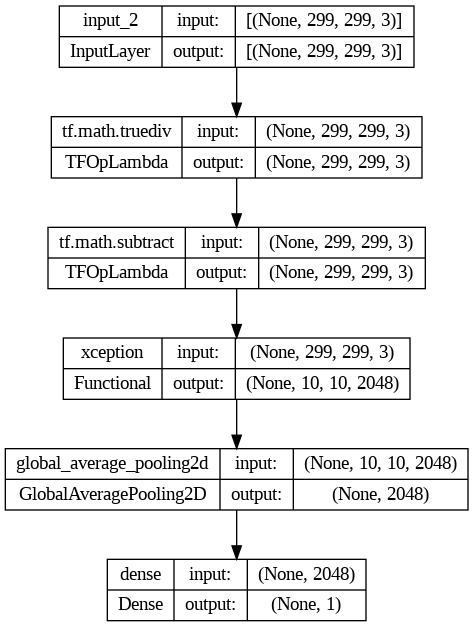

In [11]:
#add a model on top of the base model

inputs = keras.Input(shape = INPUT_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = keras.applications.xception.preprocess_input(inputs)
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

keras.utils.plot_model(model, show_shapes=True)
#keras.utils.plot_model(base_model, show_shapes=True)

In [12]:
#train on the new model
model.compile(optimizer=keras.optimizers.Adam(),
              loss = keras.losses.MeanSquaredError(),
              metrics = [keras.losses.MeanSquaredError()])
model.fit(train_generator, epochs=20, validation_data= validation_generator) #, callbacks=...

Epoch 1/20
40/40 [==============================] - 706s 17s/step - loss: 4132496.2500 - mean_squared_error: 4125556.7500 - val_loss: 4069759.2500 - val_mean_squared_error: 4255433.0000
Epoch 2/20
40/40 [==============================] - 23s 581ms/step - loss: 4120267.7500 - mean_squared_error: 4106283.5000 - val_loss: 4057795.5000 - val_mean_squared_error: 4243251.0000
Epoch 3/20
40/40 [==============================] - 25s 616ms/step - loss: 4108041.5000 - mean_squared_error: 4093413.2500 - val_loss: 4045833.5000 - val_mean_squared_error: 4231069.5000
Epoch 4/20
40/40 [==============================] - 23s 567ms/step - loss: 4095840.5000 - mean_squared_error: 4099256.7500 - val_loss: 4033892.5000 - val_mean_squared_error: 4218910.0000
Epoch 5/20
40/40 [==============================] - 23s 569ms/step - loss: 4083748.2500 - mean_squared_error: 4064530.5000 - val_loss: 4022009.7500 - val_mean_squared_error: 4206808.5000
Epoch 6/20
40/40 [==============================] - 23s 579ms/step

In [14]:
model.save("/content/drive/My Drive/dataset_AA2/model_1_Xception_20epo_1200data.keras")